# Imports and Setup

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 1000)
import json
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.svm import LinearSVC
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


# **Please input your own directory path towards the root location where this file is**

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# # sihan
# %cd "../gdrive/My Drive/CZ4045 " 

# chuanxin
%cd "../gdrive/My Drive/Group Work/CZ4045" 

Mounted at /gdrive
/gdrive/My Drive/Group Work/CZ4045


# Preprocessing of Data

## Load in data

In [ ]:
# Load airpods reviews into dataframe
airpods_df = pd.read_csv('Q3_folder/data_airpods_reviews.csv')
airpods_df.head(2)

,Link,Stars,Reviews,Nouns,Adjectives,Sentiment,Remarks
0,https://www.amazon.com/gp/customer-reviews/R31ZK5M0UWDZ4R?ASIN=B07PXGQC1Q,1,"Poor quality microphone. Not suitable for a remote worker taking calls. If your job requires dictation or a high quality mic, go elsewhere","microphone, mic","poor quality, high quality",negative,NaN
1,https://www.amazon.com/gp/customer-reviews/R13AIAX16Y8XXM/ref=cm_cr_getr_d_rvw_ttl?ie=UTF8&ASIN=B07PXGQC1Q,5,"These are the best pair of wireless earphones I ever came across, apple has definitely done it again. Being an apple fan, I love these! They are so easy to connect! Once I connected them to my iPhone, they were seamlessly connected to my other apple devices. All I have to do is select them in the list from the device you need them to connect and you are good to go. Another good thing is turning them on/off is easy, just remove them from the charging case and they turn on and put them back to turn them off, its simple. And like most of the earphones out there, they connect to the last device you used them with, but its easy to switch device. You have the flexibility to just use one piece, if you like and sometimes it does come handy. Another function I like is the automatic ear detection, just remove a piece from you ear and playback will pause and resume once you put it back, this does help when someone drops by for a conversation and you don't need to actually pickup your phone to pause the playback. The battery life is definitely impressive, I need to charge the case every 2 days. And it's easy to carry everywhere, it being so small. Now the sound quality is crisp and connection is smooth, I found that the 2nd gen AirPods are actually better and improved on 1st gen, but its not worth to upgrade, but if you are planning to get your first one, I would definitely say go for the 2nd gen AirPods, I got a pretty sweet deal on amazon and am very happy with my purchase.","pair of earphones, battery life, sound quality, connectino, deal","best, definitely impressive, crisp, smooth, pretty sweet",positive,NaN


# Sentiment Analysis

In [ ]:
# Load amazon reviews into dataframe
amazon_json_list = []
with open('Q3_folder/Cell_Phones_and_Accessories_5.json', 'r') as file:
    for line in tqdm(file):
        amazon_json_list.append(json.loads(line))

amazon_json_list[0]

1128437it [00:15, 74438.12it/s] 


{'asin': '7508492919',
 'overall': 5.0,
 'reviewText': 'Looks even better in person. Be careful to not drop your phone so often because the rhinestones will fall off (duh). More of a decorative case than it is protective, but I will say that it fits perfectly and securely on my phone. Overall, very pleased with this purchase.',
 'reviewTime': '08 4, 2014',
 'reviewerID': 'A24E3SXTC62LJI',
 'reviewerName': 'Claudia Valdivia',
 'style': {'Color:': ' Bling'},
 'summary': "Can't stop won't stop looking at it",
 'unixReviewTime': 1407110400,
 'verified': True}

In [ ]:
# some entries have missing values, clean them out
amazon_json_list_clean = []
for amazon_json in tqdm(amazon_json_list, total=len(amazon_json_list), position=0, leave=True):
  try:
    amazon_json_list_clean.append({'Reviews': amazon_json['reviewText'], 'Stars': int(amazon_json['overall'])})
  except:
    pass

100%|██████████| 1128437/1128437 [00:01<00:00, 888145.43it/s]


In [ ]:
amazon_df = pd.DataFrame(amazon_json_list_clean)               
amazon_df.head()

,Reviews,Stars
0,"Looks even better in person. Be careful to not drop your phone so often because the rhinestones will fall off (duh). More of a decorative case than it is protective, but I will say that it fits perfectly and securely on my phone. Overall, very pleased with this purchase.",5
1,When you don't want to spend a whole lot of cash but want a great deal...this is the shop to buy from!,5
2,"so the case came on time, i love the design. I'm actually missing 2 studs but nothing too noticeable the studding is almost a bit sloppy around the bow, but once again not too noticeable. I haven't put in my phone yet so this is just what I've notice so far",3
3,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY WERE OKAY WITH IT. JUST NOT WHAT I EXPECTED.,2
4,"I liked it because it was cute, but the studs fall off easily and to protect a phone this would not be recommended. Buy if you just like it for looks.",4


In [ ]:
# We will truncate this dataset because it is so huge - len(amazon_df) = 1 127 672
amazon_df = amazon_df[:150000]
len(amazon_df)

150000

In [ ]:
amazon_df.groupby("Stars").count()

,Reviews
Stars,
1,12384
2,8947
3,15905
4,27433
5,85331


## Train-Eval Loop
We will explore three different models and pick the best model for our sentiment analysis application. The models are as follows
1. MNB - Multinomial Naive Bayes
2. SGDC - Stochastic Gradient Descent Classifier
3. LSVC - Linear Support Vector Classifier

Note: Training may take awhile as LSVC is a computationally expensive algorithm, and  accuracy may fluctuate slightly 

### 1-5 Rating (Review Rating Stars)

In [ ]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

ngram_seq = [(1,1), (2,2), (3,3), (1,2), (1,3), (2,3)]

# Create empty dataframe for sentiment results
stars_results_df = pd.DataFrame()

# Loop through various ngram_sequence to find the best result
for ngram in tqdm(ngram_seq, total=len(ngram_seq), position=0, leave=True):
  # Initialise count vectorizer and fit text_counts for both amazon and airpods dataset
  cv = CountVectorizer(stop_words='english', ngram_range=ngram, tokenizer = token.tokenize)
  text_counts = cv.fit_transform(amazon_df.Reviews.tolist() + airpods_df.Reviews.tolist())

  amazon_text_counts = text_counts[:-len(airpods_df)]
  airpods_text_counts = text_counts[-len(airpods_df):]
  X_train = amazon_text_counts
  y_train = amazon_df.Stars

  # MNB Classifier
  MNB = MultinomialNB()
  MNB.fit(X_train, y_train)

  # SGD Classifier
  SGDC = SGDClassifier()
  SGDC.fit(X_train, y_train)

  # LSVC Classifier
  LSVC = LinearSVC()
  LSVC.fit(X_train, y_train)

  # Generate airpods accuracy for each model
  airpods_accuracy_MNB = metrics.accuracy_score(MNB.predict(airpods_text_counts), airpods_df.Stars)
  airpods_accuracy_LSVC = metrics.accuracy_score(LSVC.predict(airpods_text_counts), airpods_df.Stars)
  airpods_accuracy_SGDC = metrics.accuracy_score(SGDC.predict(airpods_text_counts), airpods_df.Stars)

  # Append results to dataframe
  stars_results_df = stars_results_df.append({
      "ngram": ngram,
      "MNB":  airpods_accuracy_MNB,
      "LSVC": airpods_accuracy_LSVC,
      "SGDC": airpods_accuracy_SGDC,
  }, ignore_index=True)

  # Print results for logging
  print("=" * 50)
  print("NGRAM:", ngram)
  print("MNB, LSVC, SGDC:", airpods_accuracy_MNB, airpods_accuracy_LSVC, airpods_accuracy_SGDC)

  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
 17%|█▋        | 1/6 [03:54<19:33, 234.65s/it]

NGRAM: (1, 1)
MNB, LSVC, SGDC: 0.5333333333333333 0.5666666666666667 0.6666666666666666


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
 33%|███▎      | 2/6 [08:20<16:16, 244.09s/it]

NGRAM: (2, 2)
MNB, LSVC, SGDC: 0.4666666666666667 0.6 0.6666666666666666


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
 50%|█████     | 3/6 [15:59<15:25, 308.53s/it]

NGRAM: (3, 3)
MNB, LSVC, SGDC: 0.23333333333333334 0.6666666666666666 0.6666666666666666


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
 67%|██████▋   | 4/6 [21:16<10:21, 310.97s/it]

NGRAM: (1, 2)
MNB, LSVC, SGDC: 0.5666666666666667 0.6333333333333333 0.7


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
 83%|████████▎ | 5/6 [29:28<06:05, 365.39s/it]

NGRAM: (1, 3)
MNB, LSVC, SGDC: 0.5666666666666667 0.6666666666666666 0.6333333333333333


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
100%|██████████| 6/6 [37:27<00:00, 374.59s/it]

NGRAM: (2, 3)
MNB, LSVC, SGDC: 0.36666666666666664 0.5333333333333333 0.6


### 0-2 Rating (Sentiment)
Sentiment is a three-category representation of our ratings, which has five categories. 

Representation:
- 0: Negative (Corresponds to 1 and 2 Star Ratings)
- 1: Neutral (Corresponds to 3 Star Ratings)
- 2: Positive (Corresponds to 4 and 5 Star Ratings)

In [ ]:
# Helper function to categorize sentiment to negative, neutral, positive based on star rating
def categorize_sentiment(value):
  value = int(value)
  if value >= 4:
    return 2
  if value == 3: 
    return 1
  else:
    return 0

# Apply helper function to amazon and airpods dataframes
amazon_df['Sentiment_Category'] = amazon_df['Stars'].apply(categorize_sentiment)
airpods_df['Sentiment_Category'] = airpods_df['Stars'].apply(categorize_sentiment)

In [ ]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

ngram_seq = [(1,1), (2,2), (3,3), (1,2), (1,3), (2,3)]

# Create empty dataframe for sentiment results
sentiment_results_df = pd.DataFrame()

# Loop through various ngram_sequence to find the best result
for ngram in tqdm(ngram_seq, total=len(ngram_seq), position=0, leave=True):
  # Initialise count vectorizer and fit text_counts for both amazon and airpods dataset
  cv = CountVectorizer(stop_words='english', ngram_range=ngram, tokenizer = token.tokenize)
  text_counts = cv.fit_transform(amazon_df.Reviews.tolist() + airpods_df.Reviews.tolist())
  amazon_text_counts = text_counts[:-len(airpods_df)]
  airpods_text_counts = text_counts[-len(airpods_df):]
  X_train = amazon_text_counts
  y_train = amazon_df.Sentiment_Category


  # MNB Classifier
  MNB = MultinomialNB()
  MNB.fit(X_train, y_train)

  # SGD Classifier
  SGDC = SGDClassifier()
  SGDC.fit(X_train, y_train)

  # LSVC Classifier
  LSVC = LinearSVC()
  LSVC.fit(X_train, y_train)

  # Generate airpods accuracy for each model
  airpods_accuracy_MNB = metrics.accuracy_score(MNB.predict(airpods_text_counts), airpods_df.Sentiment_Category)
  airpods_accuracy_LSVC = metrics.accuracy_score(LSVC.predict(airpods_text_counts), airpods_df.Sentiment_Category)
  airpods_accuracy_SGDC = metrics.accuracy_score(SGDC.predict(airpods_text_counts), airpods_df.Sentiment_Category)

  # Append results to dataframe
  sentiment_results_df = sentiment_results_df.append({
      "ngram": ngram,
      "MNB":  airpods_accuracy_MNB,
      "LSVC": airpods_accuracy_LSVC,
      "SGDC": airpods_accuracy_SGDC,
  }, ignore_index=True)

  # Print results for logging
  print("=" * 50)
  print("NGRAM:", ngram)
  print("MNB, LSVC, SGDC:", airpods_accuracy_MNB, airpods_accuracy_LSVC, airpods_accuracy_SGDC)

  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
 17%|█▋        | 1/6 [02:08<10:41, 128.36s/it]

NGRAM: (1, 1)
MNB, LSVC, SGDC: 0.6 0.7333333333333333 0.8666666666666667


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
 33%|███▎      | 2/6 [04:55<09:20, 140.07s/it]

NGRAM: (2, 2)
MNB, LSVC, SGDC: 0.7 0.8 0.8


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
 50%|█████     | 3/6 [10:01<09:29, 189.84s/it]

NGRAM: (3, 3)
MNB, LSVC, SGDC: 0.2 0.8 0.7333333333333333


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
 67%|██████▋   | 4/6 [13:19<06:24, 192.19s/it]

NGRAM: (1, 2)
MNB, LSVC, SGDC: 0.8333333333333334 0.8333333333333334 0.8333333333333334


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
 83%|████████▎ | 5/6 [17:50<03:35, 215.80s/it]

NGRAM: (1, 3)
MNB, LSVC, SGDC: 0.7333333333333333 0.8 0.8333333333333334


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
100%|██████████| 6/6 [22:41<00:00, 226.91s/it]

NGRAM: (2, 3)
MNB, LSVC, SGDC: 0.5333333333333333 0.7333333333333333 0.8


### Results Evaluation

##### Prediction accuracy using number of stars for a review

In [ ]:
# Set ngram column to be index and display results
stars_results_df = stars_results_df.set_index('ngram')
print('stars_result_df')
stars_results_df.head(6)

stars_result_df


,LSVC,MNB,SGDC
ngram,,,
"(1, 1)",0.566667,0.533333,0.666667
"(2, 2)",0.600000,0.466667,0.666667
"(3, 3)",0.666667,0.233333,0.666667
"(1, 2)",0.633333,0.566667,0.700000
"(1, 3)",0.666667,0.566667,0.633333
"(2, 3)",0.533333,0.366667,0.600000


##### Prediction accuracy using sentiments for a review

In [ ]:
# Set ngram column to be index and display results
sentiment_results_df = sentiment_results_df.set_index('ngram')
print('sentiment_results_df')
sentiment_results_df.head(6)

sentiment_results_df


,LSVC,MNB,SGDC
ngram,,,
"(1, 1)",0.733333,0.600000,0.866667
"(2, 2)",0.800000,0.700000,0.800000
"(3, 3)",0.800000,0.200000,0.733333
"(1, 2)",0.833333,0.833333,0.833333
"(1, 3)",0.800000,0.733333,0.833333
"(2, 3)",0.733333,0.533333,0.800000


## Best Model Analysis
From the above results, the best model yielded is the following
- Stars: SGDC with (1,2) ngrams - Unigram and Bigrams
- Sentiment: SGDC with (1,1) ngrams - Unigram

We will now analyse the results and mismatches by plotting the confusion matrix

### 1-5 Rating (Review Rating Stars)

In [ ]:
cv = CountVectorizer(stop_words='english', ngram_range=(1,2), tokenizer = token.tokenize)
text_counts = cv.fit_transform(amazon_df.Reviews.tolist() + airpods_df.Reviews.tolist())
amazon_text_counts = text_counts[:-len(airpods_df)]
airpods_text_counts = text_counts[-len(airpods_df):]
X_train = amazon_text_counts
y_train = amazon_df.Stars

# LSVC Classifier
SGDC = SGDClassifier()
SGDC.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

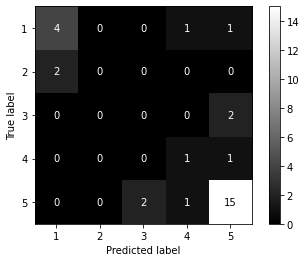

In [ ]:
plot_confusion_matrix(SGDC, airpods_text_counts, airpods_df.Stars, cmap='gray')
plt.show()

> We can observe that there are several confused values around the extreme ratings of 1 and 5

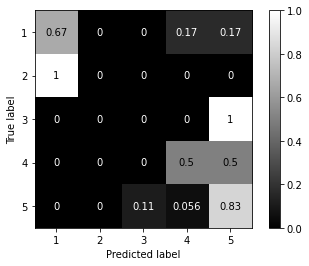

In [ ]:
plot_confusion_matrix(SGDC, airpods_text_counts, airpods_df.Stars, cmap='gray', normalize='true')
plt.show()

### 0-2 Rating (Sentiment)

In [ ]:
cv = CountVectorizer(stop_words='english', ngram_range=(1,1), tokenizer = token.tokenize)
text_counts = cv.fit_transform(amazon_df.Reviews.tolist() + airpods_df.Reviews.tolist())
amazon_text_counts = text_counts[:-len(airpods_df)]
airpods_text_counts = text_counts[-len(airpods_df):]
X_train = amazon_text_counts
y_train = amazon_df.Sentiment_Category

# SGD Classifier
SGDC = SGDClassifier()
SGDC.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

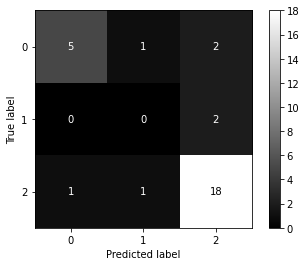

In [ ]:
plot_confusion_matrix(SGDC, airpods_text_counts, airpods_df.Sentiment_Category, cmap='gray')
plt.show()

> We can observe that true positive rates has gone up significantly with only 7 misclassifications 

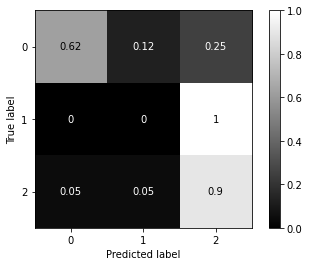

In [ ]:
plot_confusion_matrix(SGDC, airpods_text_counts, airpods_df.Sentiment_Category, cmap='gray', normalize="true")
plt.show()

#### Qualitative Analysis of reviews that were neutral (3 star rating)
The two neutral examples in the airpods Ratings Reviews were analysed qualitatively. It was observed that the inclusion of Reviews such as “high quality sound” and “impressive battery life” in these two Reviews likely caused it to be classified as a positive review.

In [ ]:
airpods_df[airpods_df.Sentiment_Category == 1].head()

,Link,Stars,Reviews,Nouns,Adjectives,Sentiment,Remarks,Sentiment_Category
27,https://www.amazon.com/gp/customer-reviews/R2D3A4ILJS8TNE/ref=cm_cr_arp_d_rvw_ttl?ie=UTF8&ASIN=B07PXGQC1Q,3,Super Convenient. Couldn’t be easier to set up! Charged fast. Impressive battery life. Loved the automatic pause sensor feature when 1 or both AirPods are removed from one’s ear.,battery life,impressive,positive,very positive description does not match the neutral rating,1
29,https://www.amazon.com/gp/customer-reviews/R2PVMSOMUKN7U9/ref=cm_cr_arp_d_rvw_ttl?ie=UTF8&ASIN=B07PXGQC1Q,3,I bought this item in prime day just to have the AirPods a bluetooth handsfree with high quality sound and easy to use. But I'm not satisfied with the battery life at all. If I talk on a phone for an hour and watch a movie for another hour the battery dies and I should recharge it using its case. So the battery life for my item is less than a few hours if I use it constantly. It seems expensive for this battery quality.,sound,high quality,negative,negative description does not match the neutral rating,1


In [ ]:
neutral_rating = airpods_df[airpods_df.Sentiment_Category == 1]
neutral_rating.drop(['Link','Nouns','Adjectives'], axis='columns', inplace=True)
neutral_rating = neutral_rating[['Reviews','Remarks','Stars','Sentiment','Sentiment_Category']]
neutral_rating

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Reviews,Remarks,Stars,Sentiment,Sentiment_Category
27,Super Convenient. Couldn’t be easier to set up! Charged fast. Impressive battery life. Loved the automatic pause sensor feature when 1 or both AirPods are removed from one’s ear.,very positive description does not match the neutral rating,3,positive,1
29,I bought this item in prime day just to have the AirPods a bluetooth handsfree with high quality sound and easy to use. But I'm not satisfied with the battery life at all. If I talk on a phone for an hour and watch a movie for another hour the battery dies and I should recharge it using its case. So the battery life for my item is less than a few hours if I use it constantly. It seems expensive for this battery quality.,negative description does not match the neutral rating,3,negative,1
